In [89]:
!echo $HOSTNAME

n-62-20-9


In [90]:
import numpy as np
import math
import scipy as sp
from scipy import interpolate
from numpy.linalg import solve
import matplotlib.pyplot as plt
from skimage.measure import profile_line
from time import time
import spekpy
import os
import skimage

In [91]:
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

from cil.io import NikonDataReader
from cil.utilities.jupyter import islicer
from cil.utilities.display import show_geometry, show2D, show1D
from cil.recon import FDK, FBP
from cil.plugins.tigre import ProjectionOperator#, FBP
from cil.processors import TransmissionAbsorptionConverter, Slicer
from cil.optimisation.algorithms import CGLS, SIRT

from cil.framework import ImageData, ImageGeometry, AcquisitionData, AcquisitionGeometry
from cil.utilities.noise import gaussian, poisson

In [92]:
def fun_attenuation():
    # mu/rho in (cm2/g)
    # multiply by density of gold to get mu in (cm^{-1})
    data = []
    # ORIGINAL DATA IN MEV!!!! SO CONVERT TO KEV
    base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
    file_path = os.path.join(base_dir,'NIST_gold_only_dat.txt')
    with open(file_path, 'r') as file:
        for line in file:
            # Split the line into components
            parts = line.split()

            # Check if the line has at least 3 elements and the first is a number
            if len(parts) >= 3 and parts[0].replace('.', '', 1).replace('E-', '', 1).replace('E+', '', 1).isdigit():
                energy = float(parts[-3])  # Energy value
                mu_rho = float(parts[-2])  # mu/rho value
                mu_en_rho = float(parts[-1])  # mu_en/rho value
                data.append((energy, mu_rho, mu_en_rho))

    # Example: Print the first few entries
    data = np.array(data)
    # print(data)
    # plt.loglog(data[:,0],data[:,1])
    # plt.show()
    # plt.loglog(data[:,0],data[:,2])
    # plt.show()


    # Assuming 'data' is a list of tuples (energy, mu_rho, mu_en_rho)
    # convert to KEV
    rho = 19.3 # g/cm^3
    # rho = 1
    energies = 1000*data[:,0]
    mu_rhos = data[:,1]
    mu = mu_rhos * rho

    ###
    # Create a spline interpolator
    # spline = interpolate.InterpolatedUnivariateSpline(energies, mu_rhos, k=1)

    # # Define a function that uses this interpolator
    # def estimate_attenuation(energy):
    #     return spline(energy)
    ###
    ###
    log_energies = np.log10(energies)
    log_mu = np.log10(mu)
    spline = interpolate.InterpolatedUnivariateSpline(log_energies, log_mu, k=1)
    def estimate_attenuation(energy):
        log_energy = np.log10(energy)  # Convert input energy to log domain
        log_attenuation = spline(log_energy)  # Perform interpolation in log domain
        return np.power(10,log_attenuation)  # Convert back to original domain
    
    
    # plt.plot(log_energies,log_mu_rhos)
    # plt.show()
    # plt.figure()
    ###
    # Generate a log-spaced range of energy values for plotting
    energy_plot_range = np.logspace(np.log10(min(energies)), np.log10(max(energies)), 500)

    # Example usage
    # energy = 0.005  # 5 keV
    # attenuation = estimate_attenuation(energy)
    # print(f"Estimated attenuation at {energy} keV is {attenuation}")

    # Plot using log-log scale
    # plt.loglog(energy_plot_range, spline(energy_plot_range), label='Spline Interpolation')  # Spline curve
    plt.loglog(energy_plot_range, estimate_attenuation(energy_plot_range), label='Spline Interpolation (Linear)')
    plt.loglog(energies, mu, 'o', label='Data Points',markersize=4)#,color='black')  # Data points


    plt.xlabel('Energy (keV)')
    plt.ylabel('Attenuation Coefficient')
    plt.title('Attenuation Coefficient vs Energy')
    plt.legend()
    plt.show()

    return estimate_attenuation

def create_circle_image(image_size, radius, center):
    # Initialize a square image with zeros (black)
    image = np.zeros((image_size, image_size))

    # Create the circle
    for x in range(image_size):
        for y in range(image_size):
            # Check if the pixel is inside the circle
            # x is now the vertical coordinate, and y is the horizontal coordinate
            if (x - center[0]) ** 2 + (y - center[1]) ** 2 < (radius+0.5) ** 2:
                image[x, y] = 1  # Set pixel value to 1 (white) inside the circle
    
    return image

def generate_triangle_image(img_size, triangle_size, corner_coords):
    """
    Generate a right triangle test image.

    Parameters:
    img_size (tuple): Size of the image (width, height)
    triangle_size (tuple): Size of the right triangle (base, height)
    corner_coords (tuple): Coordinates of the right-angled corner (x, y)
    """
    # Create a blank image
    image = np.zeros(img_size)

    # Define the triangle
    for x in range(corner_coords[0], min(corner_coords[0] + triangle_size[0], img_size[0])):
        for y in range(corner_coords[1], min(corner_coords[1] + triangle_size[1], img_size[1])):
            if (x - corner_coords[0]) + (y - corner_coords[1]) < triangle_size[0]:
                image[y, x] = 1  # Set pixel value

    return image

In [93]:
angles = np.linspace(start=0, stop=180, num=3*180//1, endpoint=False) #6
physical_size = 0.01 # cm
voxel_num = 500
voxel_size = physical_size/voxel_num

ig = ImageGeometry(voxel_num_x=voxel_num, voxel_num_y=voxel_num, voxel_size_x=voxel_size, voxel_size_y=voxel_size, center_x=0, center_y=0)

factor = 1 #4
panel_num_cells = math.ceil(np.sqrt(2)*factor*voxel_num)
# panel_num_cells = math.ceil(factor*voxel_num)
panel_cell_length = 1/factor * voxel_size
ag = AcquisitionGeometry.create_Parallel2D(ray_direction=[0,1], detector_position=[0,physical_size], detector_direction_x=[1,0], rotation_axis_position=[0,0])\
    .set_panel(num_pixels=panel_num_cells,pixel_size=panel_cell_length)\
    .set_angles(angles=angles)

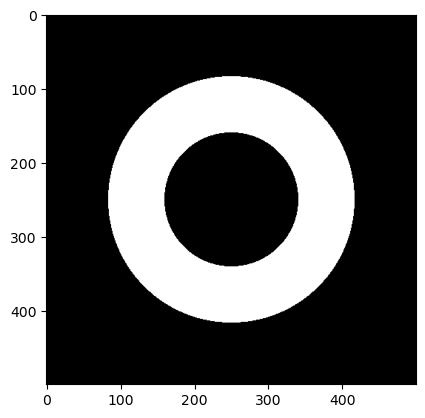

In [94]:
# im1 = create_circle_image(image_size=voxel_num, radius=voxel_num//3, center=[voxel_num//2, voxel_num//2])
im1 = create_circle_image(image_size=voxel_num, radius=voxel_num//3, center=[voxel_num//2, voxel_num//2])
im2 = create_circle_image(image_size=voxel_num, radius=voxel_num//5.5, center=[voxel_num//2, voxel_num//2])
# im_arr = im1
im_arr = im1-im2
im_arr = im_arr.astype('float32')
plt.imshow(im_arr,cmap='grey')

image = ImageData(array=im_arr,geometry=ig)

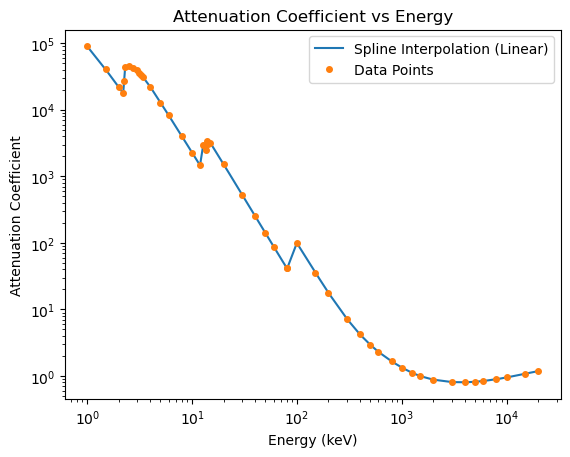

In [95]:
mu = fun_attenuation()

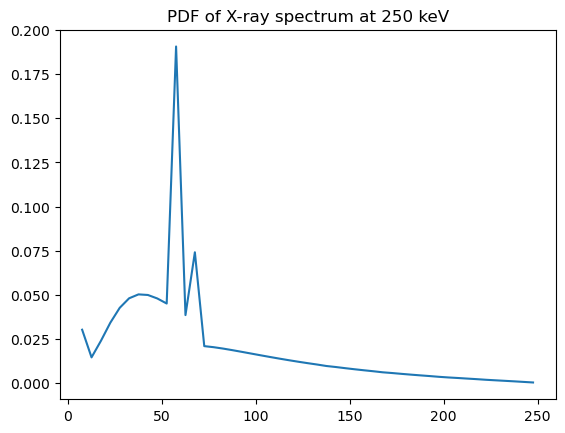

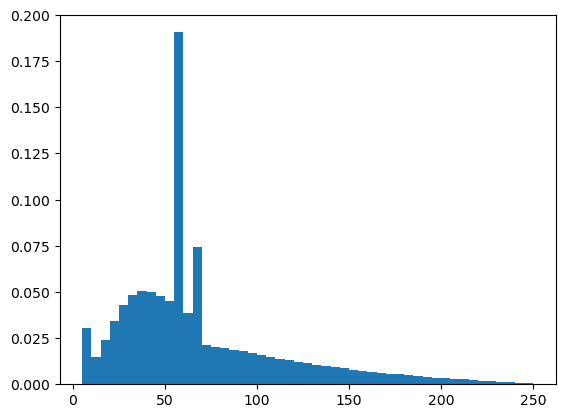

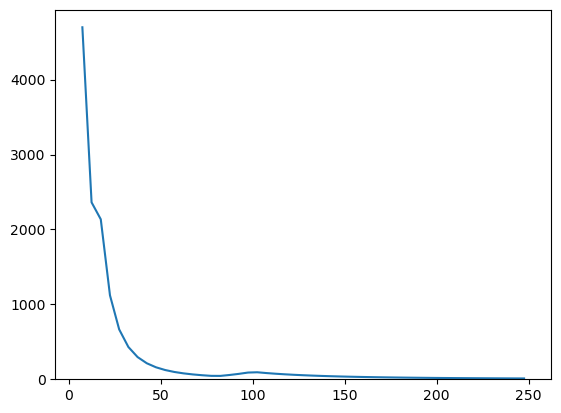

In [96]:
# tube_potential = 120 # keV
tube_potential = 250
anode_angle = 12 # deg
bin_width = 5 # keV
# spectrum = spekpy.Spek(kvp=tube_potential, th=anode_angle, dk=bin_width, mu_data_source='nist', physics='casim')
spectrum = spekpy.Spek(kvp=tube_potential, th=anode_angle, dk=bin_width, mu_data_source='nist', physics='spekcalc')
spectrum = np.array(spectrum.get_spectrum())
spectrum[1,:] /= np.sum(spectrum[1,:])
plt.plot(spectrum[0,:],spectrum[1,:])
plt.title(f'PDF of X-ray spectrum at {tube_potential} keV')
plt.show()
plt.figure()

num_bins = spectrum.shape[1]

bin_centers = spectrum[0,:]
bin_heights = spectrum[1,:]
bin_edges = np.array(bin_centers) - bin_width/2
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
plt.bar(bin_centers, bin_heights, align='center', width=np.diff(bin_edges))
# plt.plot(bin_centers-0.1, bin_heights, 'r.', markersize=5)
# plt.scatter(bin_centers, bin_heights)
plt.show()

plt.bar(bin_centers, bin_heights, align='center', width=np.diff(bin_edges))
plt.plot(bin_centers, mu(bin_centers))

In [97]:
A = ProjectionOperator(ig, ag, 'Siddon', device='gpu')
b = A.direct(image)
# b.reorder(order='tigre')
print(type(b))
print(b)
# show2D(b)

d = b.as_array()
I = np.zeros(b.shape, dtype='float32')
I0 = 0
print(d)
for i in range(num_bins):
    E = bin_centers[i]
    I0_E = bin_heights[i]
    I0 += I0_E
    I += I0_E * np.exp(-mu(E)*d)


b = AcquisitionData(array=-np.log(I/I0), geometry=ag)
b_raw = AcquisitionData(array=I, geometry=ag)
# b = data.as_array()

<class 'cil.framework.framework.AcquisitionData'>
Number of dimensions: 2
Shape: (540, 708)
Axis labels: ('angle', 'horizontal')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [98]:
print(b_raw)

Number of dimensions: 2
Shape: (540, 708)
Axis labels: ('angle', 'horizontal')



In [99]:
# E_eff = np.sum(bin_centers*bin_heights)
# print(np.sum(bin_heights))
# print(f'E_eff: {E_eff}')
# b_mono = -np.log(np.exp(-mu(E_eff)*d))

mu_eff = np.sum(bin_heights * mu(bin_centers))
# b_mono = -np.log(np.exp(-mu_eff*d))
b_mono = d*mu_eff
# b_mono = AcquisitionData(array=np.exp(-b_mono), geometry=ag)
b_mono = AcquisitionData(array=b_mono, geometry=ag)

In [100]:
# show1D(b_mono,slice_list=[('angle',0)])

In [101]:
# show1D(b_raw,slice_list=[('angle',0)])

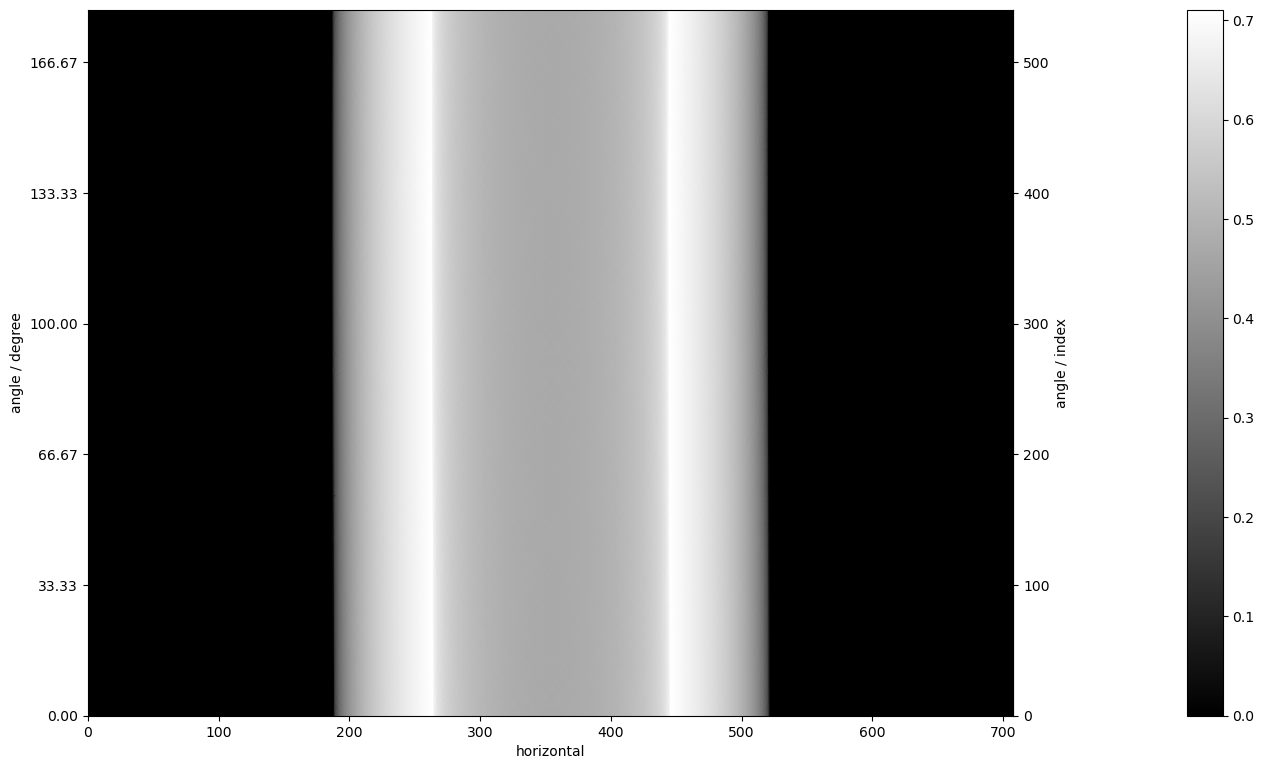

In [102]:
show2D(b)

In [103]:
print(b.geometry)

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [0.  , 0.01]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [708   1]
	Pixel size: [2.e-05 2.e-05]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 540
	Angles 0-20 in degrees:
[0.        , 0.33333334, 0.6666667 , 1.        , 1.3333334 , 1.6666666 ,
 2.        , 2.3333333 , 2.6666667 , 3.        , 3.3333333 , 3.6666667 ,
 4.        , 4.3333335 , 4.6666665 , 5.        , 5.3333335 , 5.6666665 ,
 6.        , 6.3333335 ]
Distances in units: units distance


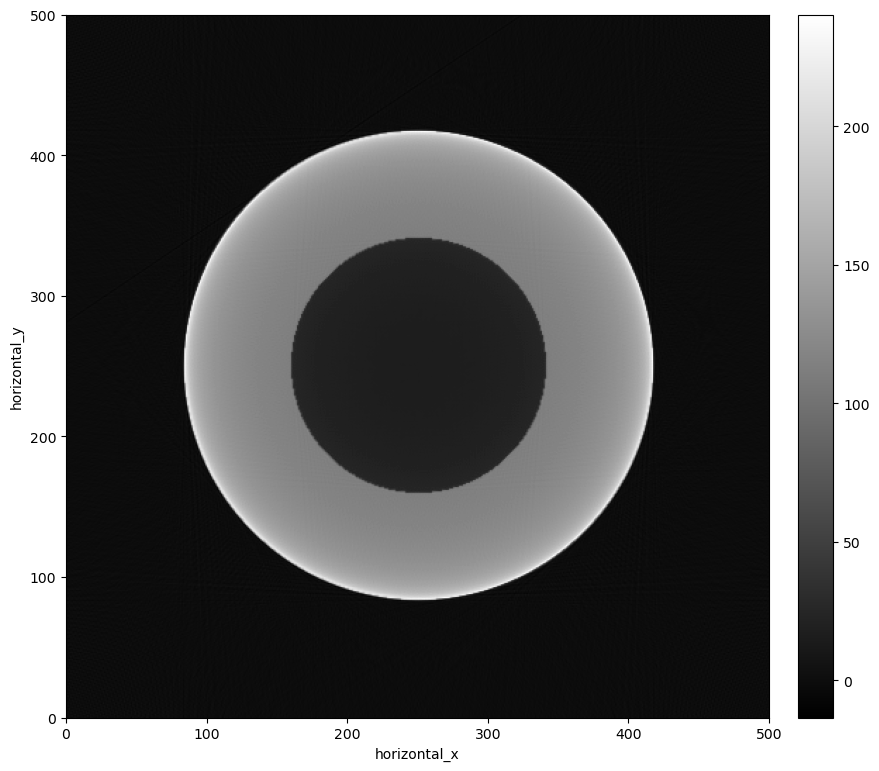

<class 'cil.framework.framework.ImageData'>
Number of dimensions: 2
Shape: (500, 500)
Axis labels: ('horizontal_y', 'horizontal_x')



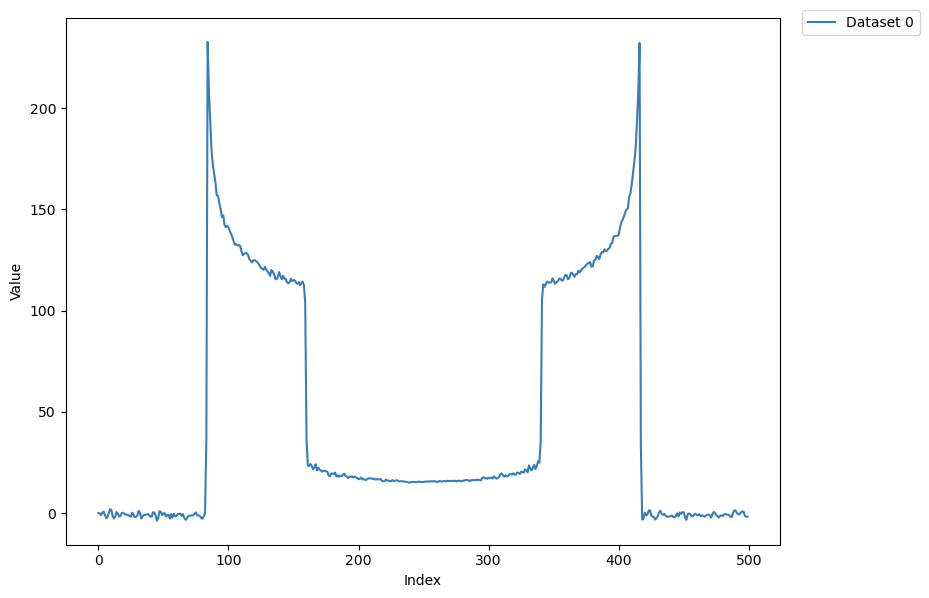

In [105]:
b.reorder(order='tigre')

# Set up and run FBP for 90-angle dataset
recon = FBP(b, image_geometry=ig, backend='tigre').run(verbose=0)
# recon = FBP(b_mono)
show2D(recon)
print(type(recon))
print(recon)
show1D(recon, slice_list=[('horizontal_y', recon.shape[0]//2)])

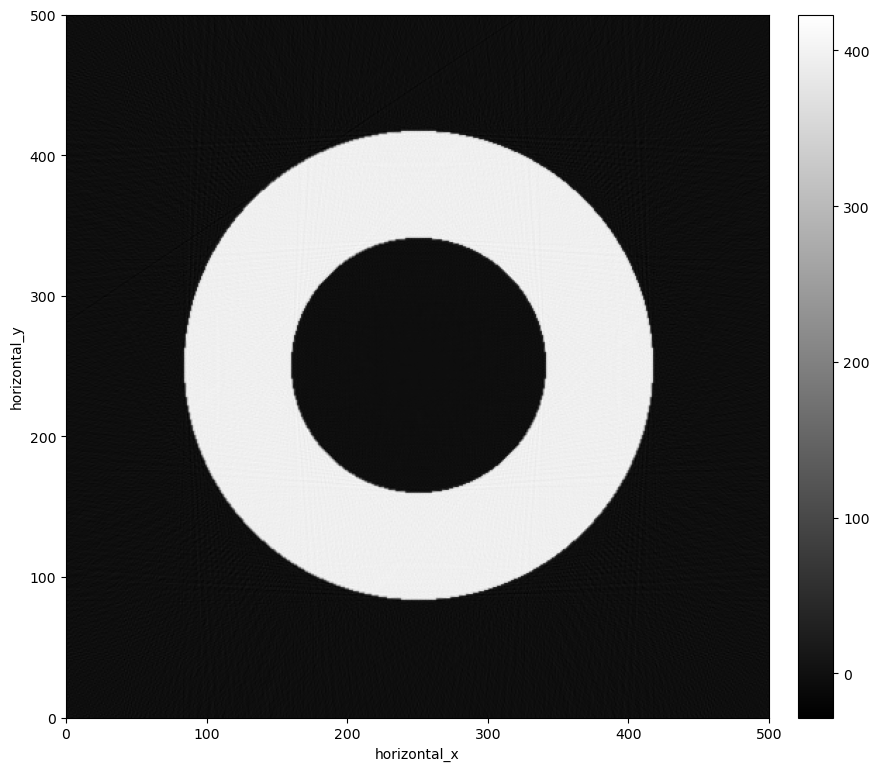

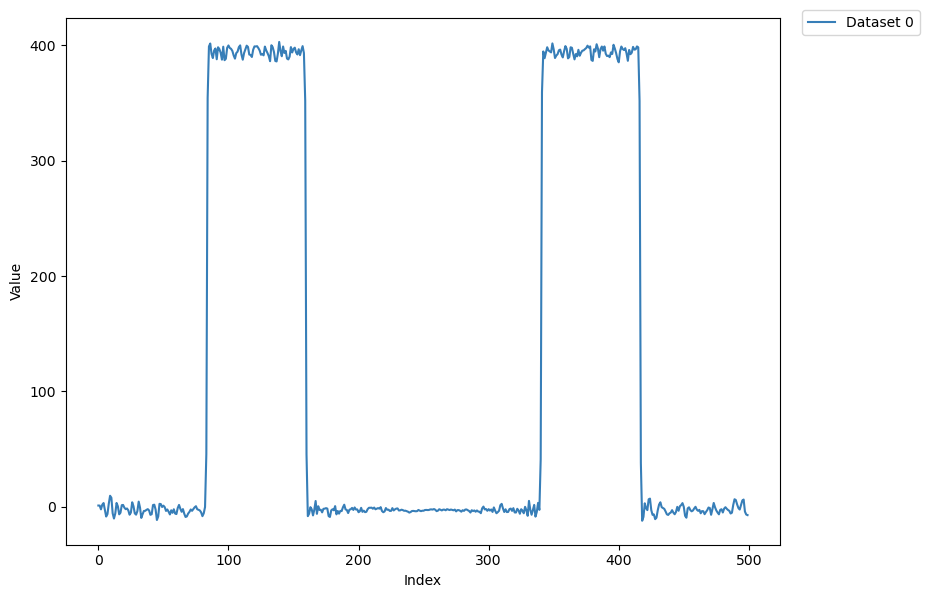

In [ ]:
# b_noisy = gaussian(b)
# recon_noisy = FBP(b, image_geometry=ig, backend='tigre').run(verbose=0)

recon_noisy = FBP(b_mono, image_geometry=ig, backend='tigre').run(verbose=0)
show2D(recon_noisy)
show1D(recon_noisy, slice_list=[('horizontal_y', recon.shape[0]//2)])

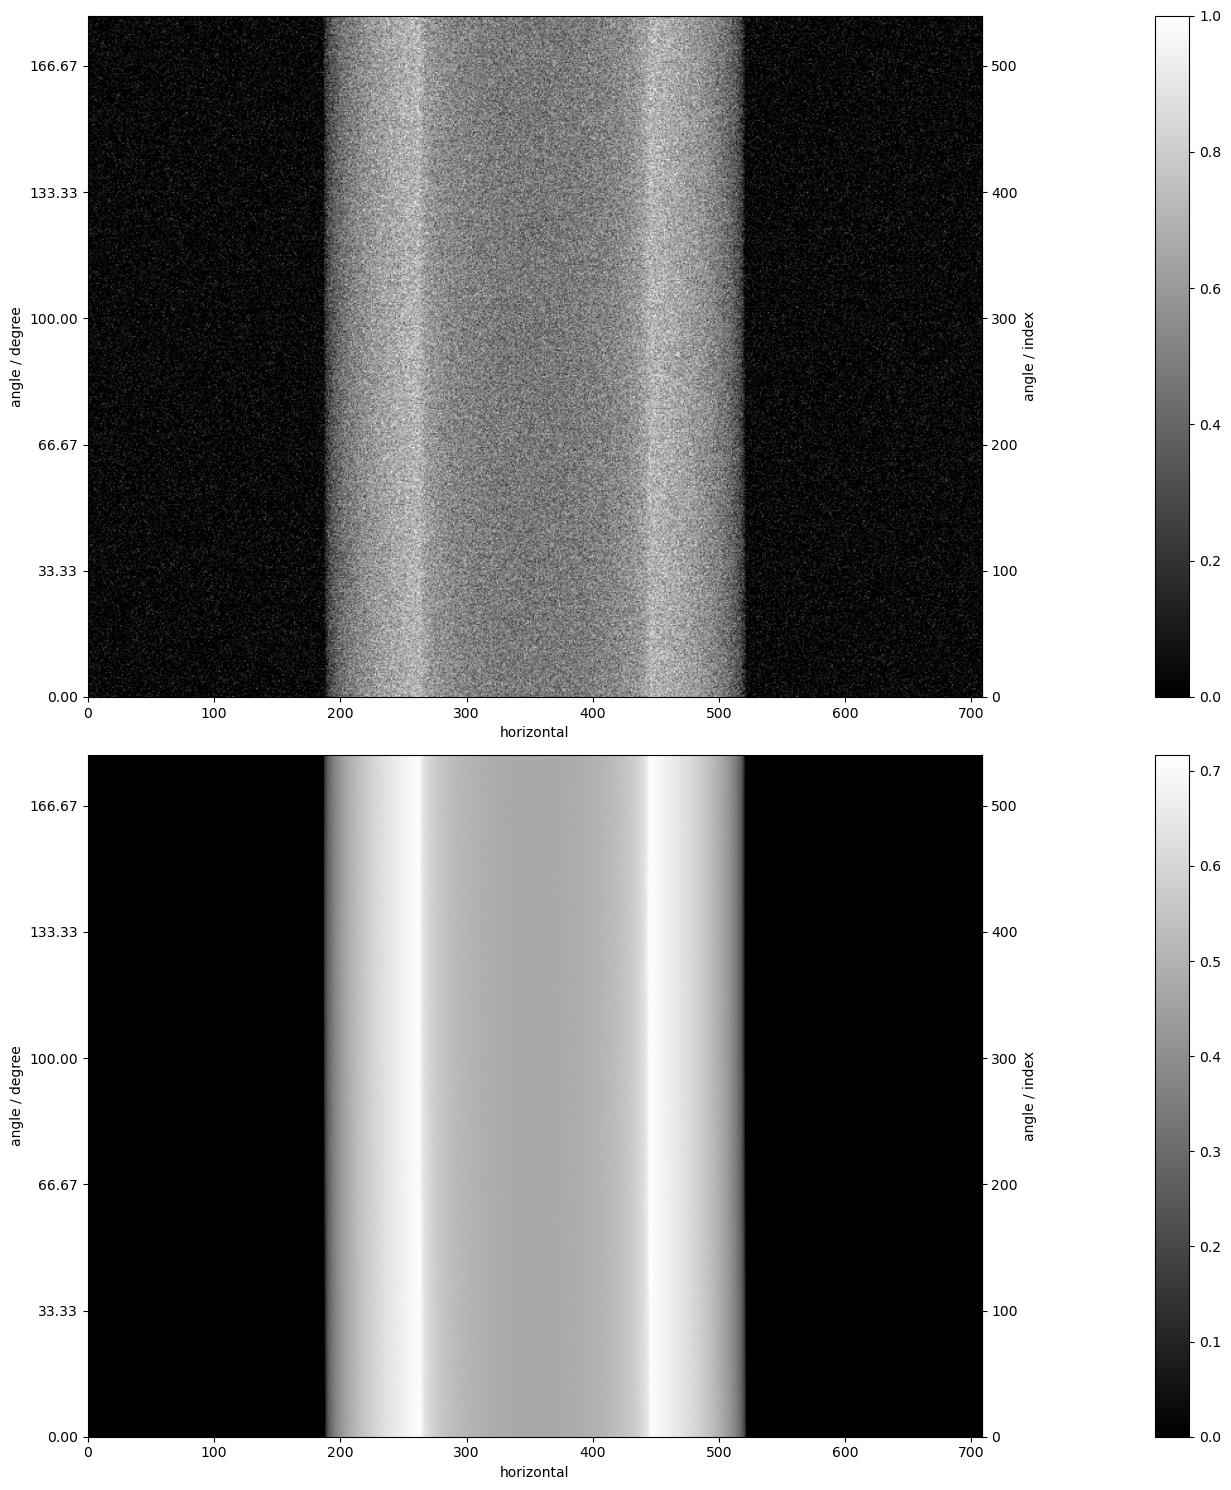

In [ ]:
show2D([gaussian(b),poisson(b)],num_cols=1)

In [ ]:
diff = poisson(b)-b
# diff = gaussian(b)-b
np.sum(np.abs(diff.as_array()))

287.69656

In [ ]:
# print(poisson(b).as_array()[100,500:600])
# print(b.as_array()[100,500:600])
print(poisson(b).as_array()[100,500:600]-b.as_array()[100,500:600])

[ 0.00373363 -0.00048339 -0.00062528  0.00019526  0.00045821  0.001416
  0.0015564   0.0003624  -0.00041986 -0.00219283  0.00012222  0.00199601
  0.00148198  0.00028926 -0.00151637  0.00071028  0.0014562  -0.00215283
  0.00059371 -0.000673    0.00072748  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0

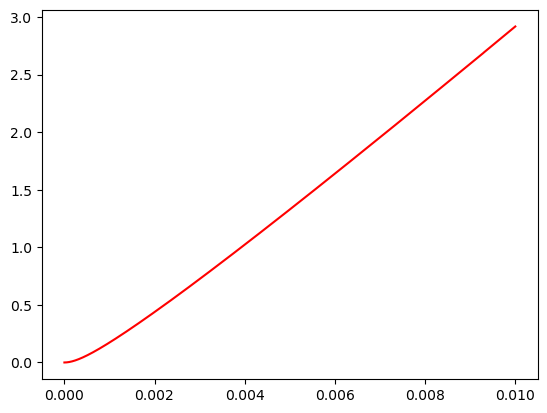

In [ ]:
base_dir = os.path.abspath('/dtu/3d-imaging-center/projects/2022_DANFIX_Vindelev/analysis/s214743_bsc/')
file_path = os.path.join(base_dir,'bh_absorption_corrections.txt')
corrections = np.loadtxt(file_path)
spline_corrections = interpolate.InterpolatedUnivariateSpline(corrections[:,0], corrections[:,1], k=1)

plt.plot(corrections[:,0], corrections[:,1],'r', label='Original Data')

flatten always returns copy

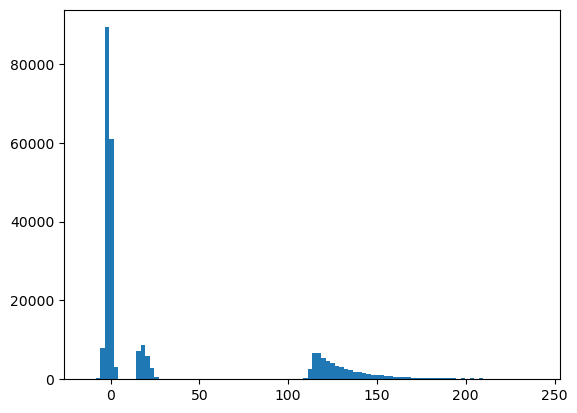

In [ ]:
plt.hist(recon.as_array().flatten(), bins=100)
plt.show()

In [ ]:
spline_corrections(np.array([[0.01,0.02],[0.1,0.05]]))

array([[ 2.91816211,  6.16303897],
       [32.12205386, 15.89766955]])

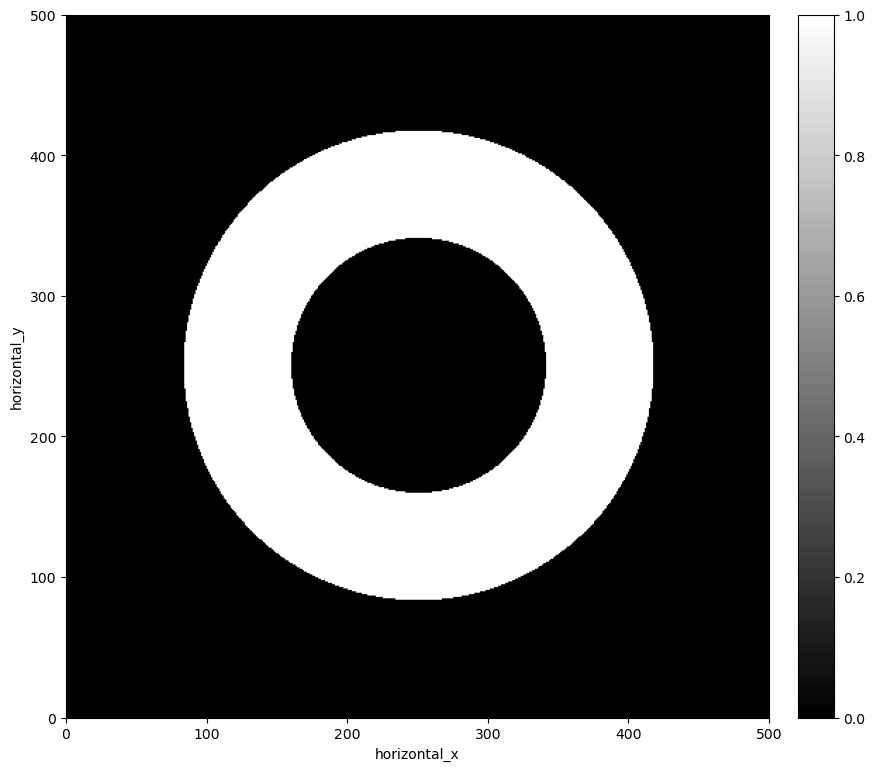

0.003165264


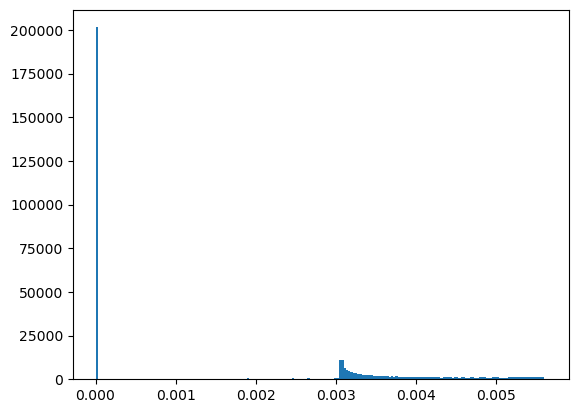

168910.17


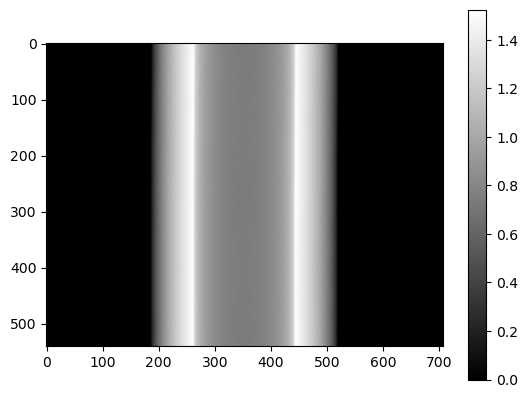

In [ ]:
recon_segmented = ImageData(array=np.array(recon > 70,dtype='float32'), geometry=ig)
show2D(recon_segmented)
path_lengths = A.direct(recon_segmented)
print(path_lengths.as_array()[500,500])
# show2D(path_lengths)
# np.max(path_lengths)
plt.hist(path_lengths.as_array().flatten(), bins=200)
plt.show()
b_corrected = b.as_array() + spline_corrections(path_lengths.as_array())
b_corrected = AcquisitionData(array=np.array(b_corrected,dtype='float32'), geometry=ag)
print(np.sum(np.abs(b.as_array()-b_corrected.as_array())))
plt.imshow(spline_corrections(path_lengths.as_array()),cmap='grey')
plt.colorbar()
# show2D([b.as_array(),b_corrected.as_array()],num_cols=1)

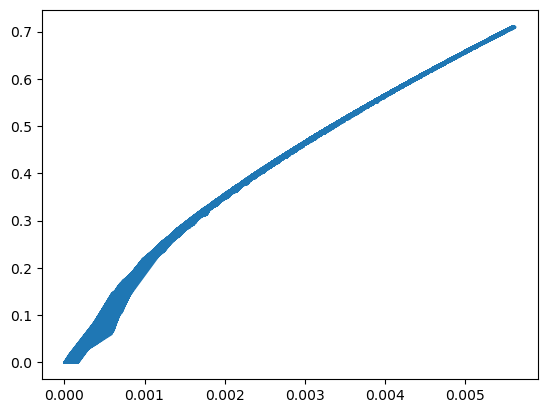

In [ ]:
plt.plot(path_lengths.as_array().flatten(),b.as_array().flatten())

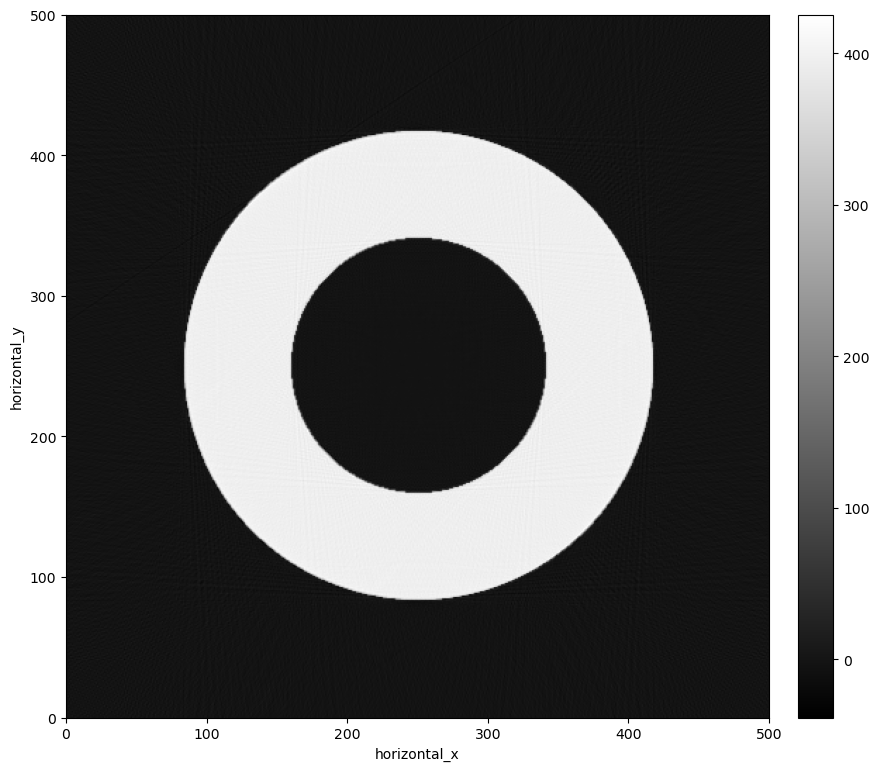

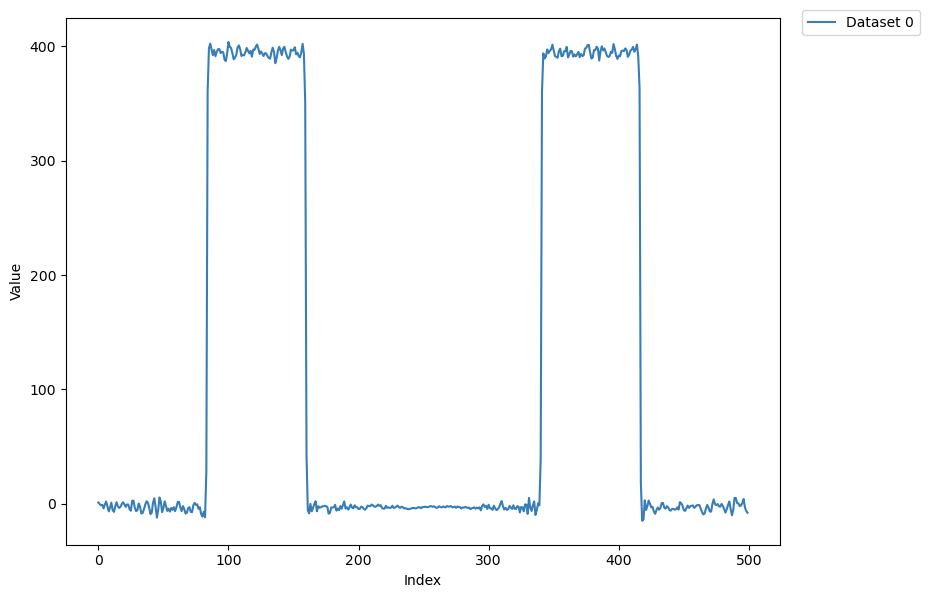

In [ ]:
b_corrected.reorder('tigre')
recon_bhc = FBP(b_corrected, image_geometry=ig, backend='tigre').run(verbose=0)
show2D(recon_bhc)
show1D(recon_bhc, slice_list=[('horizontal_y', recon.shape[0]//2)])

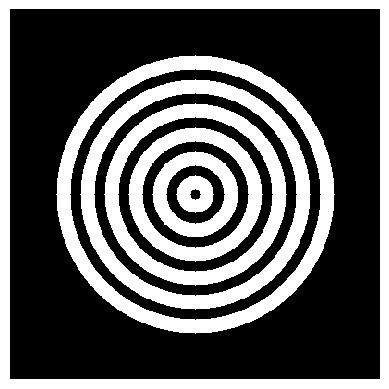

In [110]:
import numpy as np
import matplotlib.pyplot as plt

def create_rings_image(size, ring_width, spacing, radius, center):
    """
    Create a square image with concentric rings.

    Parameters:
    - size: The size of the square image (width and height) in pixels.
    - ring_width: The width of each ring in pixels.
    - spacing: The spacing between rings in pixels.
    - radius: The overall radius of the circles (from the center to the outer edge) in pixels.
    - center: A tuple (x, y) representing the center of the circles.
    """

    # Create an empty image
    image = np.zeros((size, size))

    # Generate a grid of distances from the center
    Y, X = np.ogrid[:size, :size]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    # Create rings by selecting pixels within specific distance ranges
    for r in np.arange(radius, 0, -(ring_width + spacing)):
        inner_radius = r - ring_width
        mask = (dist_from_center <= r) & (dist_from_center > inner_radius)
        image[mask] = 1  # Set pixels within the ring to white

    # Display the image
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

# Example usage
size = 400  # Image size: 400x400 pixels
ring_width = 15  # Ring width: 10 pixels
spacing = 11  # Spacing between rings: 5 pixels
radius = 150  # Overall radius of the circles: 100 pixels
center = (size // 2, size // 2)  # Center the circles in the middle of the image

create_rings_image(size, ring_width, spacing, radius, center)
